# Part 2: System Analysis & Optimization
There are two directions of interest, and the ideas were listed in the ascending order of complexity.  
Part 2 answers follows assumptions and results made from Part 1.
## Text Note Classification
Keep the quality of human written text data with consistency

## Detect Redundant Censor for Minizing Cost  
Multicolinearity (correlations between covariates)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os

In [33]:
df = pd.read_csv('./df_imp.csv')

There will be no prediction in this part, and therefore the entire data set is used (train + test).

## Text Note Classification
Assumption: Operational_Notes field is written by technician manually.   
Situation: a note is written in a new way that it does not exactly match with any of the cleaned existing Operational_Note value.   
Goal: to find the closest note for the new variation of human writing.  

In [34]:
known_notes = df['Operational_Notes'].dropna().unique().tolist()

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Fit TF-IDF on known notes
vectorizer = TfidfVectorizer()
X_known = vectorizer.fit_transform(known_notes)

def classify_note(new_note):
    # Transform the new note
    X_new = vectorizer.transform([new_note])
    
    # Compute cosine similarity
    similarities = cosine_similarity(X_new, X_known).flatten()
    
    # Find the best match
    best_idx = np.argmax(similarities)
    return known_notes[best_idx], similarities[best_idx]

In [36]:
known_notes

['no_comment',
 'Parameters logged',
 'Nominal operation',
 'Pressures stable',
 'Routine check by operator',
 'Stroke rate steady',
 'Weather condition normal',
 'Initial strokes',
 'Bringing online after workover',
 'Flowline pressured up',
 'Well restart initiated',
 'Confirming stroke length',
 'Flow consistent',
 'High motor amps',
 'Stuffing box leak',
 'Possible rod parting',
 'Flow rate drop',
 'Gas interference suspected',
 'Fluid pound detected',
 'Polished rod load erratic',
 'Temp anomaly gearbox',
 'High vibration gearbox',
 'Pressure spike tubing',
 'Stuffing box replaced',
 'Valve repair',
 'Polished rod clamp adjusted',
 'Fluid level check',
 'Pump serviced',
 'Rod string pulled',
 'Workover rig on site',
 'Gearbox oil change',
 'Paraffin cleaned',
 'Routine check',
 'VFD ramp up',
 'Well shut-in - waiting orders',
 'Waiting on flowline',
 'Well shut-in - low price',
 'Monitoring pressures',
 'Well shut-in - surface repair',
 'Checking surface equipment']

### Use Cases

In [37]:
# Example 1
note = "well was shut down for repairs"
closest_note, score = classify_note(note)
print(f"Closest note: {closest_note} (Similarity: {score:.2f})")

Closest note: Well shut-in - surface repair (Similarity: 0.60)


In [38]:
# Example 2 
note = "Pump repair done"
closest_note, score = classify_note(note)
print(f"Closest note: {closest_note} (Similarity: {score:.2f})")

Closest note: Pump serviced (Similarity: 0.53)


In [39]:
# Example 3 
# Example 2 
note = "Well starting"
closest_note, score = classify_note(note)
print(f"Closest note: {closest_note} (Similarity: {score:.2f})")

Closest note: Well restart initiated (Similarity: 0.48)


## Detect Redundant Censor for Minizing Cost 

### Correlations Between Covaraites 

#### Inbetween Numerical Values 

First, nonparametric rank correlation (Spearman) is observed. 

In [42]:
df.head()

Timestamp Well_Operating_Status Operational_Notes  \
0  2023-01-01 00:00:00             Operating        no_comment   
1  2023-01-01 00:10:00             Operating        no_comment   
2  2023-01-01 00:20:00             Operating        no_comment   
3  2023-01-01 00:30:00             Operating        no_comment   
4  2023-01-01 00:40:00             Operating        no_comment   

   Acoustic_Sensor_Env_dB  Ambient_Temperature_C  Casing_Pressure_SensorB_psi  \
0               49.227346              38.854665                    50.897459   
1               40.135114              36.311768                    49.925884   
2               51.190784              38.751977                    50.518002   
3               45.558002              40.662510                    51.624718   
4               45.064738              37.945231                    52.292048   

   Casing_Pressure_psi  Gearbox_Temperature_C  Gearbox_Vibration_mm_s  \
0            49.256230              67.367428                0.517302   
1            48.734318              71.938489                0.481706   
2            49.636435              73.476772                0.607282   
3            50.175814              72.928716                0.634475   
4            49.078709              68.188568                0.477692   

   Hydraulic_Pressure_psi  ...  Stroke_Count_Today Surface_Temperature_C  \
0               30.170903  ...                   0             64.128805   
1               29.941944  ...                   4             64.625281   
2               30.457478  ...                   8             62.624781   
3               31.381904  ...                  12             64.064278   
4               29.956880  ...                  16             63.969226   

  Tubing_Pressure_psi  VFD_Speed_pct  Monitoring_Alert  Hour  Weekday  \
0          197.273721      67.414439               0.0     0        6   
1          201.903168      86.075002               0.0     0        6   
2          198.521759      73.653432               0.0     0        6   
3          204.559909      74.619125               0.0     0        6   
4          202.119309      76.773574               0.0     0        6   

         Date  IsWeekend  WeekOfMonth  
0  2023-01-01          1            0  
1  2023-01-01          1            0  
2  2023-01-01          1            0  
3  2023-01-01          1            0  
4  2023-01-01          1            0  

[5 rows x 26 columns]

In [ ]:
categorical_cols = [
    'Operational_Notes',
    'Well_Operating_Status',
    'Lubrication_Status',
    'Maintenance_Code'
]

In [44]:
df_drp = df.drop(columns = {'Hour', 'Weekday', 'Date', 'IsWeekend', 'WeekOfMonth'})

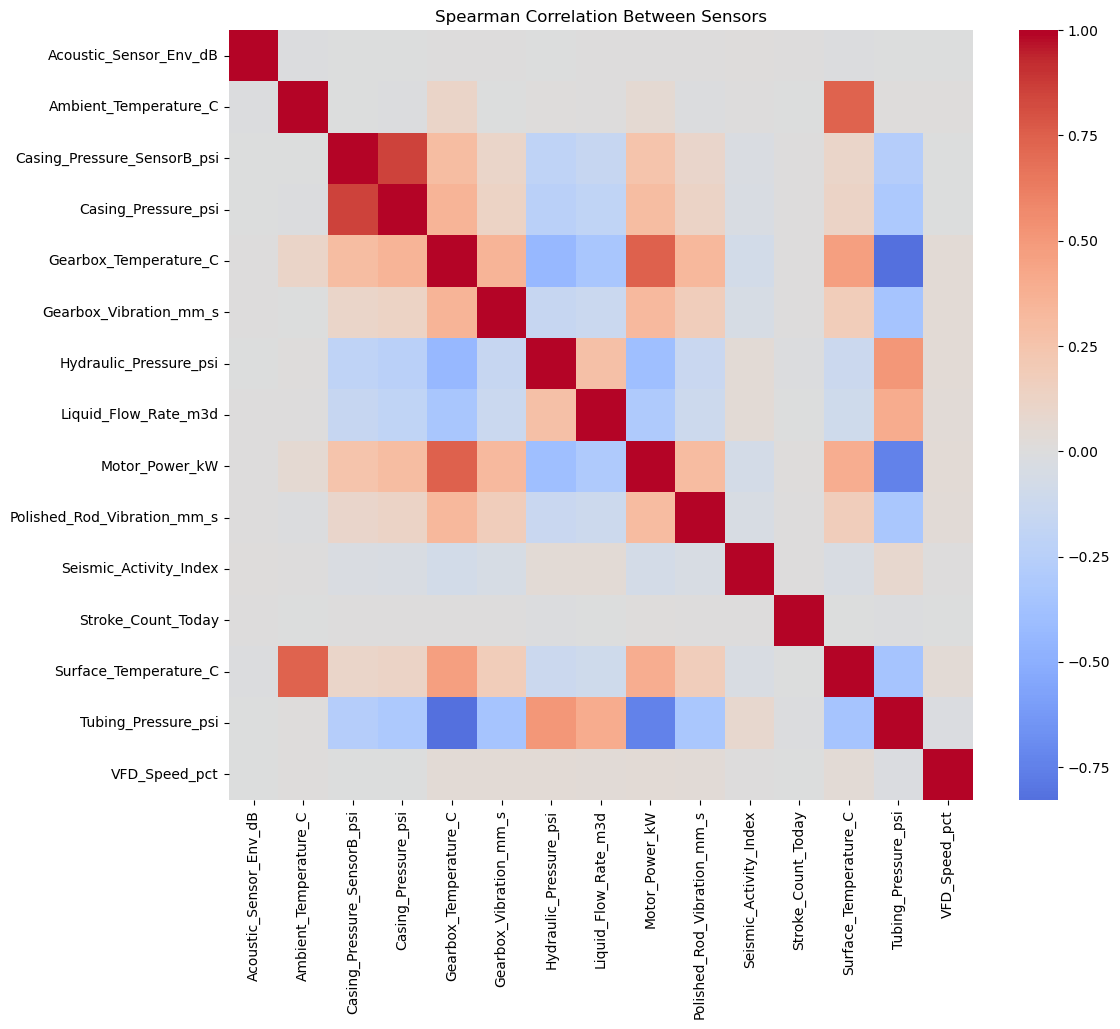

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset your numeric sensor columns 
sensor_cols = [col for col in df_drp.columns if col not in ['Well_ID', 'Timestamp', 'Monitoring_Alert', 
                                                        'Operational_Notes', 'Well_Operating_Status',
                                                       'Maintenance_Code', 'Lubrication_Status']]
sensor_data = df_drp[sensor_cols]

# Compute correlation matrix
corr_matrix = sensor_data.corr(method='spearman')

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, center=0)
plt.title("Spearman Correlation Between Sensors")
plt.show()

In [47]:
# Step 1: Take the absolute value of the correlation
abs_corr = corr_matrix.abs()

# Step 2: Unstack the matrix to a long-form DataFrame
corr_pairs = abs_corr.unstack()

# Step 3: Remove self-correlations (i.e., correlation of a variable with itself)
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Step 4: Drop duplicate pairs (since correlation is symmetric: A-B == B-A)
corr_pairs = corr_pairs.groupby([frozenset(pair) for pair in corr_pairs.index]).max()

# Step 5: Filter strong correlations (e.g., above 0.7)
strong_corr = corr_pairs[corr_pairs > 0.7].sort_values(ascending=False)

# Display the result
print(strong_corr)

(Casing_Pressure_SensorB_psi, Casing_Pressure_psi)    0.854863
(Tubing_Pressure_psi, Gearbox_Temperature_C)          0.828621
(Tubing_Pressure_psi, Motor_Power_kW)                 0.749818
(Motor_Power_kW, Gearbox_Temperature_C)               0.748297
(Surface_Temperature_C, Ambient_Temperature_C)        0.742332
dtype: float64


Moter_Power_kW, Surface_Temperature_C, and Casing_Pressure_psi were top 3 variables for supporting Monitoring_Alert prediction from part 1. 
As 5 strong positive Spearman nonparametric correlation shown above, Ambyint may consider not measuring correlated features with the top 3 variables. For example, Casing_Pressure_SensorB_psi could be detached in case of the maintanance/installation cost of the sensor is not economical, as Casing_Pressure_psi gives more informative sensoring data in regard of solving Part 1 problem.

### Inbetween Categorical Variables

Notice that there are plenty of missing values on categorical variables, and the missing values are assumed to be another category based on the context of variable name and row-wise missing cases. 

In [48]:
from scipy.stats import chi2_contingency

def cramers_v_matrix(df):
    # Select only categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    result = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

    for col1 in cat_cols:
        for col2 in cat_cols:
            if col1 == col2:
                result.loc[col1, col2] = np.nan  # optional: set self-pairs to NaN
            else:
                # Cross-tabulate and compute Cramér's V
                confusion_matrix = pd.crosstab(df[col1], df[col2])
                chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
                n = confusion_matrix.sum().sum()
                phi2 = chi2 / n
                r, k = confusion_matrix.shape
                v = np.sqrt(phi2 / min(k - 1, r - 1))
                result.loc[col1, col2] = v

    return result

In [59]:
categorical_cols = [
    'Operational_Notes',
    'Well_Operating_Status',
    'Lubrication_Status',
    'Maintenance_Code'
]
for col in categorical_cols:
    if col in df.columns:
        df[col] = pd.Categorical(df[col])

In [60]:
df[categorical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50984 entries, 0 to 50983
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Operational_Notes      50984 non-null  category
 1   Well_Operating_Status  50984 non-null  category
 2   Lubrication_Status     50984 non-null  category
 3   Maintenance_Code       50984 non-null  category
dtypes: category(4)
memory usage: 201.2 KB


In [61]:
df_result = cramers_v_matrix(df[categorical_cols])

In [62]:
df_result

Operational_Notes  Well_Operating_Status  \
Operational_Notes                    NaN               0.877226   
Well_Operating_Status           0.877226                    NaN   
Lubrication_Status              0.025173               0.020880   
Maintenance_Code                0.027047               0.029026   

                       Lubrication_Status  Maintenance_Code  
Operational_Notes                0.025173          0.027047  
Well_Operating_Status            0.020880          0.029026  
Lubrication_Status                    NaN          0.011649  
Maintenance_Code                 0.011649               NaN

It is shown that Operational_Notes and Well_Operating_Status are very strongly associated. There could be MNAR or MAR relationships between them.


If it were any of the cases, then straightforwardly remove one:
1. When there is no operational note then there is always no operating status
2. When there is no operating status, then there is always missing operational notes.

In case 1., operating status is strictly less informative than the note, so the status variable could be skipped to be collected.
In case 2., operational note is strictly less informative than the status, then the effort to write the note could be saved. 

In [68]:
var1 = 'Operational_Notes'
var2 = 'Well_Operating_Status'

In [69]:
miss_op = df[var1]=='no_comment'

In [70]:
miss_we = df[var2]=='Operating'

In [71]:
table = pd.crosstab(miss_op, miss_we)

In [73]:
print(f"Missingness relationship between '{var1}' and '{var2}':\n")
print(table)

Missingness relationship between 'Operational_Notes' and 'Well_Operating_Status':

Well_Operating_Status  False  True 
Operational_Notes                  
False                    548   1744
True                     172  48520


It is found that both of cases are possible where:

1. There is an operational notes, but there is no well operating status.
2. There is well operating status avaiable, but there is no operational notes.


It is still possible to save the cost to collect operating status since from Part 1 since: 
a. operating status was the least informative feature from feature importance plot
b. operational note was the most informative feature from feature importance plot with 0.48 importance. 

It is likely to be the situation that the two variables are manually logged by a maintenance technician, and they sometimes only log the status but not write a note (172), but more likely they write a note but do not log the status (1744). The effort could be saved for the technicians of logging status, as notes are more informative.

# Other Potential Directions 
## Idea 3: Early Warning System 
Probability of red flag: bivariate result utilization with logistic regression   
Algorithm (rules/models) for not too late intervention 

## Idea 4: Operating Regime Profiling (template)
- Cluster sensor patterns when the system is normal
- Compare clusters between alert vs. normal conditions
- Propose operating guidelines or thresholds to avoid alerts